In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

from sae.sparse_autoencoder import *
from sae.activation_store import *
from sae.train import ModelTrainer
from sae.config import create_config, log_config, Config
from sae.metrics import *
from sae.utils import get_blog_checkpoint, get_blog_sparsity, create_lineplot_histogram

from transformer_lens import HookedTransformer, utils
from sae.metrics import compute_metrics_post_by_text

import plotly.express as px
import plotly.graph_objs as go


In [2]:
from huggingface_hub import hf_hub_download
REPO_ID = "eoinf/pythia_saes"
# resid_pre_layer_24 :
FILENAME = "desert-oath-8/sparse_autoencoder_EleutherAI/pythia-2.8b-deduped_blocks.24.hook_resid_pre_s20480_92155904.pt"
# resid_pre_layer_10 :
# FILENAME = "absurd-dust-9/sparse_autoencoder_EleutherAI/pythia-2.8b-deduped_blocks.10.hook_resid_pre_s20480_92155904.pt"
# resid_pre_layer_11 (best one):
FILENAME = "polished-wildflower-12/sparse_autoencoder_EleutherAI/pythia-2.8b-deduped_blocks.11.hook_resid_pre_s20480_327675904.pt"

In [3]:
filename = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
sae = load_saved_sae(filename)

(…)ks.11.hook_resid_pre_s20480_327675904.pt:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [4]:
model = model_store_from_sae(sae)

/root/miniconda3/envs/arena-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-2.8b-deduped into HookedTransformer
Moving model to device:  cuda


In [6]:
sae.cfg

Config(model_name='EleutherAI/pythia-2.8b-deduped', hook_point='blocks.11.hook_resid_pre', hook_point_layer=11, hook_point_head_index=None, flatten_activations_over_layer=False, d_in=2560, different_output=False, hook_point_output=None, hook_point_layer_output=None, hook_point_head_index_output=None, flatten_activations_over_layer_output=False, d_out=None, dataset=None, is_dataset_tokenized=False, use_cached_activations=False, cached_activations_path=None, loop_dataset=False, fine_tune_dataset=False, n_batches_in_store_buffer=128, store_batch_size=8, train_batch_size=4096, context_size=256, remove_bos_tokens=False, adam_beta1=0.9, adam_beta2=0.999, log_to_wandb=True, wandb_project='test_gemma_2b', wandb_log_frequency=10, eval_frequency=500, sparsity_log_frequency=5000, n_checkpoints=80, checkpoint_path='../outputs/checkpoints', expansion_factor=8, b_dec_init_method='zeros', subtract_b_dec_from_inputs=False, from_pretrained_path=None, use_gated_sparse_autoencoder=False, normalise_w_dec=

In [5]:
activation_store = ActivationStoreAnalysis(sae.cfg, model)

ValueError: Dataset must be specified.

In [7]:
scores = compute_recovered_loss(sae,
                                activation_store,
                                model,
                                sae.cfg.hook_point,
                                n_batches=2)

In [8]:
scores

{'score': 0.8978802921132227,
 'loss': 2.6953442096710205,
 'recons_loss': 3.4280753135681152,
 'zero_abl_loss': 9.870561599731445,
 'unrecovered_loss_frac': 0.10211970788677727,
 'frac_loss_added': 0.27185066058280105}

In [9]:
metrics = compute_metrics_post(sae,
                               activation_store,
                               model,
                               save_learned_activations=False,
                               n_batches=100,
                               len_prefix=5)

In [10]:
metrics

{'l0': 29.540441513061523,
 'l0_std': 8.385501861572266,
 'mean_activation': 0.020537912845611572,
 'std_activation': 1.1683253049850464,
 'per_token_l2_loss': 2977.878173828125,
 'total_variance': 15409.9677734375,
 'explained_variance': 0.7004427909851074,
 'unexplained_variance': 0.29955726861953735,
 'mse': 4764.60498046875,
 'l2_norm_ratio': 0.971323549747467,
 'old_explained_variance': 0.9280368089675903,
 'sparsity': tensor([4.1504e-05, 1.9849e-03, 2.6855e-05,  ..., 5.8838e-04, 2.5537e-03,
         3.1738e-05], device='cuda:0'),
 'token_df':            str_tokens     unique_token  \
 0       <|endoftext|>  <|endoftext|>/0   
 1            ·details       ·details/1   
 2                 ·of            ·of/2   
 3                ·the           ·the/3   
 4                ·Los           ·Los/4   
 ...               ...              ...   
 409595             em           em/123   
 409596         ·right       ·right/124   
 409597           ·out         ·out/125   
 409598         

In [62]:
bins = np.arange(-6, 0, 0.05)
xvals, yvals = create_lineplot_histogram(metrics['sparsity'].log10().cpu().numpy(), bins=bins)

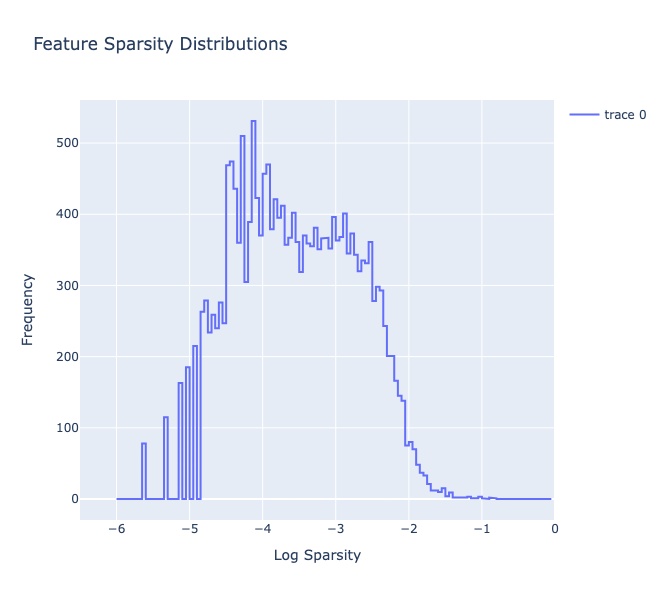

In [63]:

bins = np.arange(-6, 0, 0.05)
xvals, yvals = create_lineplot_histogram(metrics['sparsity'].log10().cpu().numpy(), bins=bins)

fig = go.Figure()
trace = go.Scatter(x=xvals, y=yvals, mode='lines')
fig.add_trace(trace)

# Add layout settings
fig.update_layout(
    title="Feature Sparsity Distributions",
    xaxis_title="Log Sparsity",
    yaxis_title="Frequency",
    # xaxis_type="log",
    # yaxis_type="log",
    xaxis_range=[-6.5, 0],
    showlegend=True,
    height=600,  # Specify the height of the figure
    width=800,  # Specify the width of the figure
)

fig.show()

### Generate text

In [11]:
default_kwargs = {'max_new_tokens': 100,
                  # 'return_dict_in_generate': True,
                   # 'output_scores': True,
                   'do_sample': True,
                   'temperature': 0.7}

In [12]:
model.generate("Q: Who is Harry Potter?", **default_kwargs)

  0%|          | 0/100 [00:00<?, ?it/s]

"Q: Who is Harry Potter?\n\nA: Harry Potter is the main character of Harry Potter and the Philosopher's Stone. He is the first person that Harry meets. He is a normal, average, British boy who is forced to go to the Hogwarts school of Witchcraft and Wizardry. He is an excellent student, and as the story progresses, he gets more and more powerful.\n\nQ: What is the relationship between Harry and his friends?\n\nA: Harry's best friends are Ron We"

In [13]:
model.generate("Q: Who is Harry Potter?", **default_kwargs)

  0%|          | 0/100 [00:00<?, ?it/s]

"Q: Who is Harry Potter?\n\nA: Harry Potter is a fictional character from J. K. Rowling's Harry Potter series of novels. The character is a wizard who is a direct descendant of Grindelwald, a powerful dark wizard from the future.\n\nQ: Who is Hermione Granger?\n\nA: Hermione Granger is the best friend of Harry Potter. She is a witty, intelligent, and attractive girl who is a genius with magic. She is also a very strong"

In [15]:
default_kwargs = {'max_new_tokens': 100,
                  # 'return_dict_in_generate': True,
                   # 'output_scores': True,
                   'do_sample': True,
                   'temperature': 0.5}
model.generate("Q: Who is Harry Potter?", **default_kwargs)

  0%|          | 0/100 [00:00<?, ?it/s]

'Q: Who is Harry Potter?\n\nA: Harry Potter is a fictional character who is the main protagonist of the Harry Potter books. He is a wizard who is born in the year 5,962 on May 31, according to the Gregorian calendar. He is a member of the Order of the Phoenix, a group of wizards who oppose Voldemort.\n\nQ: Why is Harry Potter a wizard?\n\nA: Harry Potter is a wizard because he was born on May 31, the birthday of'

In [16]:
default_kwargs = {'max_new_tokens': 100,
                  # 'return_dict_in_generate': True,
                   # 'output_scores': True,
                   'do_sample': True,
                   'temperature': 0.3}
model.generate("Q: Who is Harry Potter?", **default_kwargs)

  0%|          | 0/100 [00:00<?, ?it/s]

"Q: Who is Harry Potter?\n\nA: Harry Potter is a fictional character in J.K. Rowling's Harry Potter series of novels. He is the main character of the first book, Harry Potter and the Philosopher's Stone, and the second book, Harry Potter and the Chamber of Secrets. He is also the main character of the third book, Harry Potter and the Prisoner of Azkaban.\n\nQ: What is Harry Potter?\n\nA: Harry Potter is a fictional character in J"

In [18]:
default_kwargs = {'max_new_tokens': 100,
                  # 'return_dict_in_generate': True,
                   # 'output_scores': True,
                   'do_sample': True,
                   'temperature': 0.4}
model.generate("Q: Who is Harry Potter?", **default_kwargs)

  0%|          | 0/100 [00:00<?, ?it/s]

'Q: Who is Harry Potter?\n\nA: Harry Potter is a fictional character created by J.K. Rowling. He is a boy who is a part of the magical world of Hogwarts School of Witchcraft and Wizardry. He is the main protagonist of the Harry Potter series of books.\n\nQ: What is Harry Potter?\n\nA: Harry Potter is a fictional character created by J.K. Rowling. He is a boy who is a part of the magical world of Hogwarts'

In [20]:
harry_potter_raw_data_file = "../who_is_harry_potter/data/raw_data.txt"
with open(harry_potter_raw_data_file, "r") as file:
    harry_potter_raw_data = file.read()

In [46]:
hp_raw_subset = harry_potter_raw_data[:30000]

all_tokens = model.to_tokens(hp_raw_subset, truncate=False).squeeze()
max_size = 2048 * (all_tokens.shape[0] // 2048)
all_tokens = all_tokens[:max_size].unsqueeze(dim=0).reshape(-1, 2048)

In [79]:
all_tokens.shape

torch.Size([3, 2048])

In [80]:
3 // 1

3

In [88]:
from transformer_lens.utils import tokenize_and_concatenate

In [89]:
from datasets import Dataset


In [95]:
harry_potter_raw_data_file = "../who_is_harry_potter/data/raw_data.txt"
with open(harry_potter_raw_data_file, "r") as file:
    harry_potter_raw_data = file.readlines()

hp_raw_subset = harry_potter_raw_data[:30000]


In [98]:
# Create a dictionary with the lines
data_dict = {"text": [line.strip() for line in hp_raw_subset]}

# Create a Dataset from the dictionary
dataset = Dataset.from_dict(data_dict)

In [99]:
dataset

Dataset({
    features: ['text'],
    num_rows: 30000
})

In [100]:
act_store_test = ActivationStoreAnalysis(sae.cfg, model, dataset=dataset)

buffer
dataloader


In [85]:
%load_ext autoreload
%autoreload 2

from sae.metrics import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
metrics_subset = compute_metrics_post(sae,
                     act_store_test,
                     model,
                     save_learned_activations=False,
                     n_batches=100,
                     len_prefix=5)

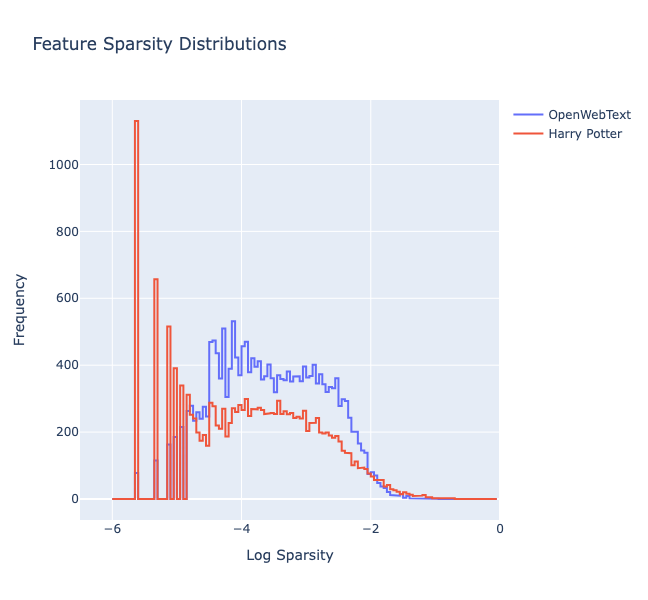

In [107]:
fig = go.Figure()


bins = np.arange(-6, 0, 0.05)

xvals, yvals = create_lineplot_histogram(metrics['sparsity'].log10().cpu().numpy(), bins=bins)
trace = go.Scatter(x=xvals, y=yvals, mode='lines', name="OpenWebText")
fig.add_trace(trace)

xvals, yvals = create_lineplot_histogram(metrics_subset['sparsity'].log10().cpu().numpy(), bins=bins)
trace = go.Scatter(x=xvals, y=yvals, mode='lines', name="Harry Potter")
fig.add_trace(trace)



# Add layout settings
fig.update_layout(
    title="Feature Sparsity Distributions",
    xaxis_title="Log Sparsity",
    yaxis_title="Frequency",
    # xaxis_type="log",
    # yaxis_type="log",
    xaxis_range=[-6.5, 0],
    showlegend=True,
    height=600,  # Specify the height of the figure
    width=800,  # Specify the width of the figure
)

fig.show()

In [120]:
keep_vals = torch.logical_and(metrics['sparsity'] > 3e-5, metrics_subset['sparsity'] > 3e-5)

In [121]:
original_sparsity = metrics['sparsity'][keep_vals]
hp_sparsity = metrics_subset['sparsity'][keep_vals]

In [122]:
ratio = hp_sparsity/original_sparsity
vals, inds = ratio.sort(descending=True)

In [124]:
vals[:10], inds[:10]

(tensor([764.1667, 759.0372, 422.7647, 263.6508, 225.1000, 188.6154, 185.4566,
         141.4727, 127.0746, 117.7857], device='cuda:0'),
 tensor([ 4644,  4538, 10111,  9887,  6780,  2328,  3526,  8619,  9833,  9070],
        device='cuda:0'))

In [126]:
original_sparsity[inds[:10]]

tensor([5.8594e-05, 9.8389e-04, 4.1504e-05, 1.5381e-04, 4.8828e-05, 3.1738e-05,
        9.8389e-04, 1.3428e-04, 1.6357e-04, 3.4180e-05], device='cuda:0')

In [24]:
metrics_with_text = compute_metrics_post(sae,
                               activation_store,
                               model,
                               save_learned_activations=True,
                               n_batches=20,
                               len_prefix=5)

Concatenating learned activations


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.50 GiB. GPU 

In [19]:
feature_id = 301

metrics_with_text['token_df']["feature"] = utils.to_numpy(metrics_with_text['learned_activations'][:, feature_id])
df = metrics_with_text['token_df'][['str_tokens','prefix', 'suffix',  'context', 'batch', 'pos', 'feature']]
df.sort_values("feature", ascending=False).head(100).style.background_gradient("coolwarm")

,str_tokens,prefix,suffix,context,batch,pos,feature
81105,·near,·with·a·player·that·is,·6,·with·a·player·that·is|·near|·6,633,81,49.115376
63988,·near,"·past,·expecting·2·in",·future,"·past,·expecting·2·in|·near|·future",499,116,42.629047
86193,·near,·surrender·to·police·in·the,·future,·surrender·to·police·in·the|·near|·future,673,49,42.448147
143874,·to,<|endoftext|>·close,·300,<|endoftext|>·close|·to|·300,1124,2,39.239086
84717,·near,·similar·price·cuts·in·the,·future,·similar·price·cuts·in·the|·near|·future,661,109,39.078022
87523,·near,.“↩ ↩ They·were,·the,.“↩ ↩ They·were|·near|·the,683,99,34.842793
71967,·Near,.·Photograph:·Tracey,my,.·Photograph:·Tracey|·Near|my,562,31,34.053497
34348,·near,·eyeglasses·for·both,·and,·eyeglasses·for·both|·near|·and,268,44,31.290394
134486,·to,",·but·was·close·enough",·a,",·but·was·close·enough|·to|·a",1050,86,28.328636
66525,·near,·a·blend·group·with·or,·your,·a·blend·group·with·or|·near|·your,519,93,26.984209
